In [ ]:
pip install torch transformers

In [ ]:
import re

# Lists to store the parsed data
dates = []
filenames = []
descriptions = []

# Regular expression to match URLs
url_pattern = r'https?://\S+'

# Read the file and parse the entries
with open('tweets.txt', 'r', encoding='utf-8') as file:
    # Split the content by blank lines to separate entries
    entries = file.read().strip().split('\n\n')

    for entry in entries:
        lines = entry.strip().split('\n')
        if len(lines) == 3:  # Ensure the entry is complete
            dates.append(lines[0])
            filenames.append(lines[1])
            # Remove URL from the description and add to list
            descriptions.append(re.sub(url_pattern, '', lines[2]))

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

# Initialize the model and tokenizer
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Query the device and use it (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to the right device

# Function to compute embeddings
def compute_embeddings(texts):
    # Tokenize texts and prepare input tensors
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
    encoded_input = {key: val.to(device) for key, val in encoded_input.items()}  # Move input tensors to the right device
    with torch.no_grad():  # Inference mode
        model_output = model(**encoded_input)
        # Extract embeddings (assuming using mean pooling for simplicity, adjust if using CLS token)
        embeddings = model_output.last_hidden_state.mean(dim=1)
    return embeddings.cpu().numpy()  # Convert to NumPy array for easier handling, move back to CPU for numpy compatibility

embeddings = compute_embeddings(descriptions)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


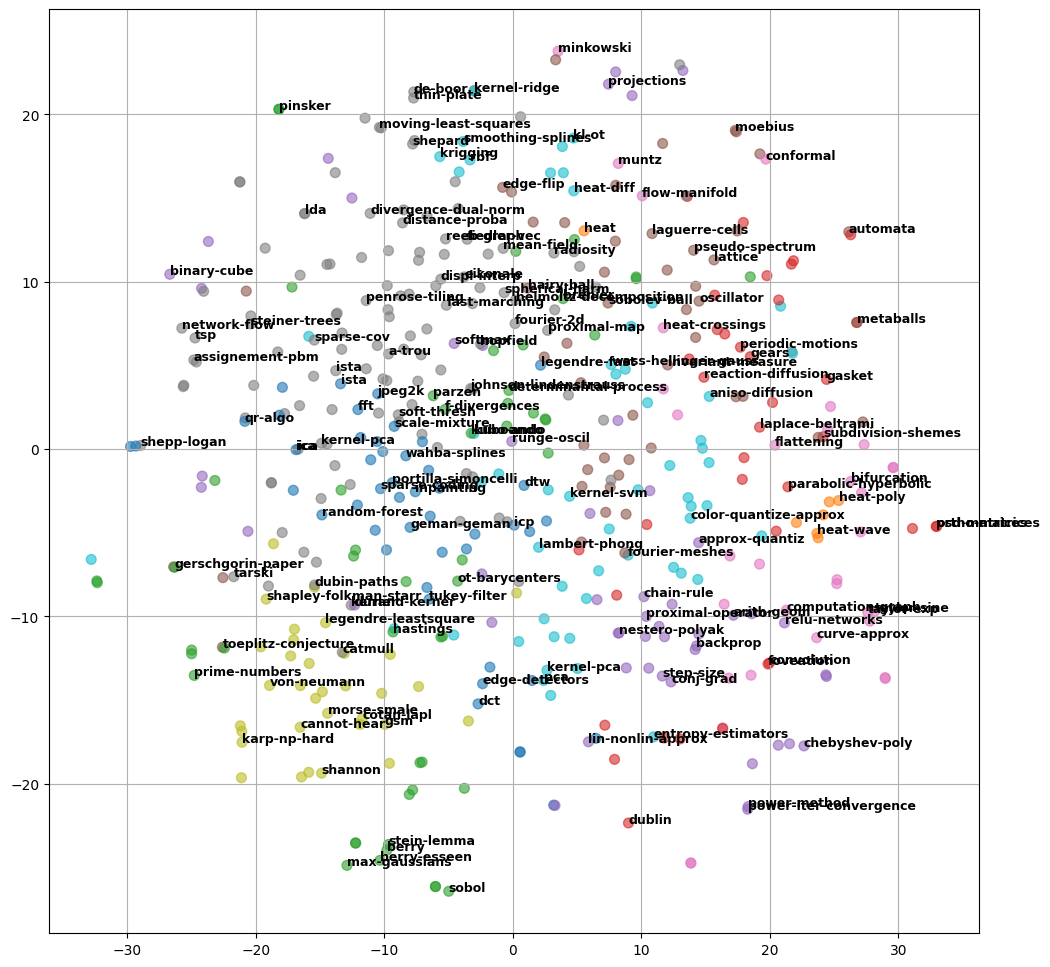

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import re  # For regex operations

# Assuming 'embeddings' is already defined and contains your high-dimensional data
# Process filenames: remove numbers, extensions, and hyphens
processed_filenames = [re.sub(r'^\d+-', '', re.sub(r'\.\w+$', '', fname)) for fname in filenames]

# Perform clustering in the high-dimensional space
num_clusters = 10  # Adjust based on your data
kmeans_high = KMeans(n_clusters=num_clusters, random_state=42).fit(embeddings)

# Perform t-SNE dimensionality reduction
tsne_model = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d_tsne = tsne_model.fit_transform(embeddings)

# Plot all points with t-SNE embeddings
plt.figure(figsize=(12, 12))  # Increase figure size for better readability
plt.scatter(embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1], c=kmeans_high.labels_, cmap='tab10', s=50, alpha=0.6)  # Color points by their high-dimensional cluster label

# Label a larger number of points
num_labels = 150  # Increased number of points you want to label
label_indices = np.linspace(0, len(embeddings) - 1, num_labels).astype(int)  # Equally spaced indices
for idx in label_indices:
    plt.text(embeddings_2d_tsne[idx, 0], embeddings_2d_tsne[idx, 1], processed_filenames[idx], fontdict={'weight': 'bold', 'size': 9})

#plt.title('t-SNE plot with selected labels')
#plt.xlabel('Dimension 1')
#plt.ylabel('Dimension 2')
plt.grid(True)  # Optional: adds a grid for easier visualization
plt.show()

plt.savefig('tsne_plot.png') # , dpi=300, bbox_inches='tight'  # Adjust 'dpi' for resolution, 'bbox_inches' for border
